In [1]:
!pip install pandas numpy matplotlib openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, zipfile

file_path = "/content/Data Analytics Assignment.xlsx"
output_folder = "/content/analysis_output"
plots_folder = os.path.join(output_folder, "plots")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(plots_folder, exist_ok=True)

In [3]:
excel = pd.ExcelFile(file_path)
print("sheets found:", excel.sheet_names)
dfs = []
for s in excel.sheet_names:
    df = pd.read_excel(file_path, sheet_name=s, header=3)
    df.dropna(how="all", inplace=True)
    df["Sheet"] = s
    df["Type"] = "Invalid" if "invalid" in s.lower() else "Valid"
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)
print("Combined shape:", data.shape)
display(data.head())

sheets found: ['Valid 1', 'Valid 2', 'Valid 3', 'Invalid 1', 'Invalid 2', 'Invalid 3']
Combined shape: (564, 14)


Unnamed: 0                 Date  unique_idfas  unique_ips  unique_uas  \
0         NaN     11 Sep to 15 Sep       1191603     1189884          28   
1         NaN           Daily Data           NaN         NaN         NaN   
2         NaN                 Date  unique_idfas  unique_ips  unique_uas   
3         NaN  2025-09-11 00:00:00         93345       93340          22   
4         NaN  2025-09-12 00:00:00        515646      515307          25   

   total_requests  requests_per_idfa  impressions  impressions_per_idfa  \
0         1770702           1.485983            0                     0   
1             NaN                NaN          NaN                   NaN   
2  total_requests  requests_per_idfa  impressions  impressions_per_idfa   
3           99280           1.063581            0                     0   
4          649515           1.259614            0                     0   

   idfa_ip_ratio  idfa_ua_ratio       IVT    Sheet   Type  
0       1.001445       42557.25  0.004276  Valid 1  Valid  
1            NaN            NaN       NaN  Valid 1  Valid  
2  idfa_ip_ratio  idfa_ua_ratio       IVT  Valid 1  Valid  
3       1.000054    4242.954545  0.003456  Valid 1  Valid  
4       1.000658       20625.84  0.003409  Valid 1  Valid

In [4]:
data.columns = [c.strip().replace(" ", "_").lower() for c in data.columns]
num_cols = ["total_requests","unique_idfas","impressions","unique_ips","unique_uas"]
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

data.dropna(subset=["unique_idfas","unique_ips","unique_uas"], inplace=True)
print("After cleaning:", data.shape)

After cleaning: (540, 14)


In [5]:
data["requests_per_idfa"] = data["total_requests"]/data["unique_idfas"]
data["impressions_per_idfa"] = data["impressions"]/data["unique_idfas"]
data["idfa_ip_ratio"] = data["unique_idfas"]/data["unique_ips"]
data["idfa_ua_ratio"] = data["unique_idfas"]/data["unique_uas"]
display(data.head())

unnamed:_0                 date  unique_idfas  unique_ips  unique_uas  \
0         NaN     11 Sep to 15 Sep     1191603.0   1189884.0        28.0   
3         NaN  2025-09-11 00:00:00       93345.0     93340.0        22.0   
4         NaN  2025-09-12 00:00:00      515646.0    515307.0        25.0   
5         NaN  2025-09-13 00:00:00      406993.0    406729.0        25.0   
6         NaN  2025-09-14 00:00:00      400917.0    400668.0        26.0   

   total_requests  requests_per_idfa  impressions  impressions_per_idfa  \
0       1770702.0           1.485983          0.0                   0.0   
3         99280.0           1.063581          0.0                   0.0   
4        649515.0           1.259614          0.0                   0.0   
5        473346.0           1.163032          0.0                   0.0   
6        467152.0           1.165209          0.0                   0.0   

   idfa_ip_ratio  idfa_ua_ratio       ivt    sheet   type  
0       1.001445   42557.250000  0.004276  Valid 1  Valid  
3       1.000054    4242.954545  0.003456  Valid 1  Valid  
4       1.000658   20625.840000  0.003409  Valid 1  Valid  
5       1.000649   16279.720000  0.006033  Valid 1  Valid  
6       1.000621   15419.884615  0.003836  Valid 1  Valid

In [7]:
summary = data.groupby("sheet").agg({
    "requests_per_idfa":["mean","max"],
    "impressions_per_idfa":["mean","min"],
    "idfa_ip_ratio":["mean","max"],
    "idfa_ua_ratio":["mean","max"]
})
display(summary)
summary.to_csv(os.path.join(output_folder,"per_sheet_overview_final.csv"))

requests_per_idfa           impressions_per_idfa      idfa_ip_ratio  \
                       mean       max                 mean  min          mean   
sheet                                                                           
Invalid 1          1.045275  1.472153         0.000000e+00  0.0      1.000088   
Invalid 2          1.033268  1.350694         0.000000e+00  0.0      1.000090   
Invalid 3          1.089191  1.576075         0.000000e+00  0.0      1.000759   
Valid 1            1.042722  1.485983         0.000000e+00  0.0      1.000079   
Valid 2            1.052762  1.383971         0.000000e+00  0.0      1.000670   
Valid 3            1.057459  1.504183         6.502681e-08  0.0      0.994175   

                    idfa_ua_ratio                
                max          mean           max  
sheet                                            
Invalid 1  1.001665    144.957403   2833.265018  
Invalid 2  1.001920     19.193113    302.095568  
Invalid 3  1.018081    133.398559   2306.308824  
Valid 1    1.001445   2098.501077  42557.250000  
Valid 2    1.017062    140.941266   2280.169811  
Valid 3    1.025221   1146.377774  15166.045455

In [9]:
comparison = data.groupby("type").agg({
    "requests_per_idfa":"mean",
    "impressions_per_idfa":"mean",
    "idfa_ip_ratio":"mean",
    "idfa_ua_ratio":"mean"
})
display(comparison)
comparison.to_csv(os.path.join(output_folder,"valid_vs_invalid_summary.csv"))

requests_per_idfa  impressions_per_idfa  idfa_ip_ratio  idfa_ua_ratio
type                                                                          
Invalid           1.055911          0.000000e+00       1.000312      99.183025
Valid             1.050981          2.167560e-08       0.998308    1128.606706

In [10]:
rules = (
    (data["idfa_ua_ratio"]>5) |
    (data["requests_per_idfa"]>200) |
    (data["idfa_ip_ratio"]>3) |
    (data["impressions_per_idfa"]<0.1)
)
sus = data[rules]
print(f"Suspicious rows detected: {len(sus)}")
display(sus.head(10))
sus.to_csv(os.path.join(output_folder,"suspicious_rows.csv"),index=False)

Suspicious rows detected: 540


unnamed:_0                 date  unique_idfas  unique_ips  unique_uas  \
0          NaN     11 Sep to 15 Sep     1191603.0   1189884.0        28.0   
3          NaN  2025-09-11 00:00:00       93345.0     93340.0        22.0   
4          NaN  2025-09-12 00:00:00      515646.0    515307.0        25.0   
5          NaN  2025-09-13 00:00:00      406993.0    406729.0        25.0   
6          NaN  2025-09-14 00:00:00      400917.0    400668.0        26.0   
7          NaN  2025-09-15 00:00:00       76526.0     76519.0        21.0   
10         NaN  2025-09-11 14:00:00        3535.0      3535.0        17.0   
11         NaN  2025-09-11 15:00:00        7254.0      7254.0        17.0   
12         NaN  2025-09-11 16:00:00       13737.0     13737.0        17.0   
13         NaN  2025-09-11 17:00:00       13800.0     13800.0        18.0   

    total_requests  requests_per_idfa  impressions  impressions_per_idfa  \
0        1770702.0           1.485983          0.0                   0.0   
3          99280.0           1.063581          0.0                   0.0   
4         649515.0           1.259614          0.0                   0.0   
5         473346.0           1.163032          0.0                   0.0   
6         467152.0           1.165209          0.0                   0.0   
7          81409.0           1.063808          0.0                   0.0   
10          3577.0           1.011881          0.0                   0.0   
11          7361.0           1.014750          0.0                   0.0   
12         14073.0           1.024459          0.0                   0.0   
13         14074.0           1.019855          0.0                   0.0   

    idfa_ip_ratio  idfa_ua_ratio       ivt    sheet   type  
0        1.001445   42557.250000  0.004276  Valid 1  Valid  
3        1.000054    4242.954545  0.003456  Valid 1  Valid  
4        1.000658   20625.840000  0.003409  Valid 1  Valid  
5        1.000649   16279.720000  0.006033  Valid 1  Valid  
6        1.000621   15419.884615  0.003836  Valid 1  Valid  
7        1.000091    3644.095238  0.002968  Valid 1  Valid  
10       1.000000     207.941176  0.010695  Valid 1  Valid  
11       1.000000     426.705882         0  Valid 1  Valid  
12       1.000000     808.058824         0  Valid 1  Valid  
13       1.000000     766.666667   0.00625  Valid 1  Valid

requests_per_idfa  impressions_per_idfa  idfa_ip_ratio  \
requests_per_idfa              1.000000             -0.575386       0.606278   
impressions_per_idfa          -0.575386              1.000000      -0.997467   
idfa_ip_ratio                  0.606278             -0.997467       1.000000   
idfa_ua_ratio                  0.373975             -0.010580       0.037137   

                      idfa_ua_ratio  
requests_per_idfa          0.373975  
impressions_per_idfa      -0.010580  
idfa_ip_ratio              0.037137  
idfa_ua_ratio              1.000000

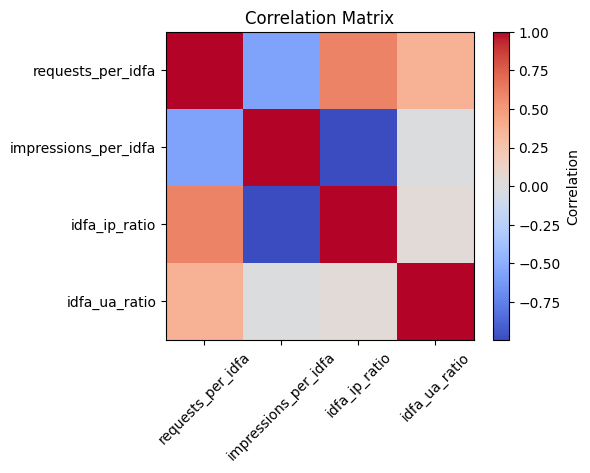

In [11]:
corr = data[["requests_per_idfa","impressions_per_idfa","idfa_ip_ratio","idfa_ua_ratio"]].corr()
display(corr)
corr.to_csv(os.path.join(output_folder,"correlation_metrics.csv"))
plt.figure(figsize=(5,4))
plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")
plt.show()

/tmp/ipython-input-1063148829.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = df_s[m].replace([np.inf,-np.inf],np.nan).fillna(method='ffill').fillna(0)


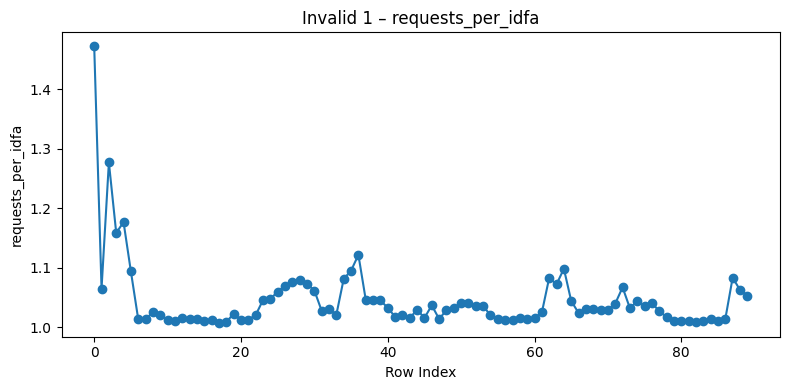

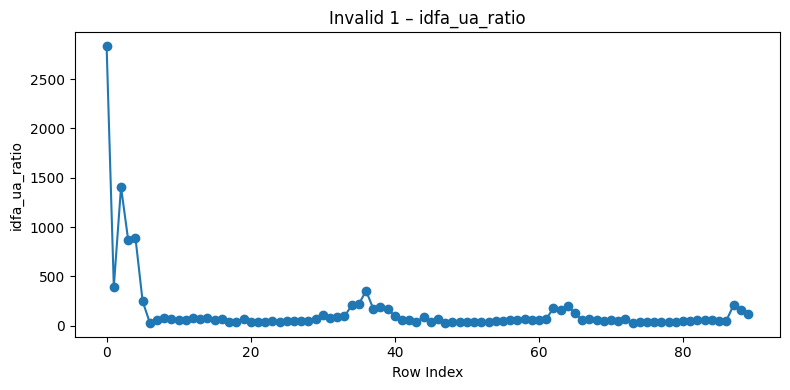

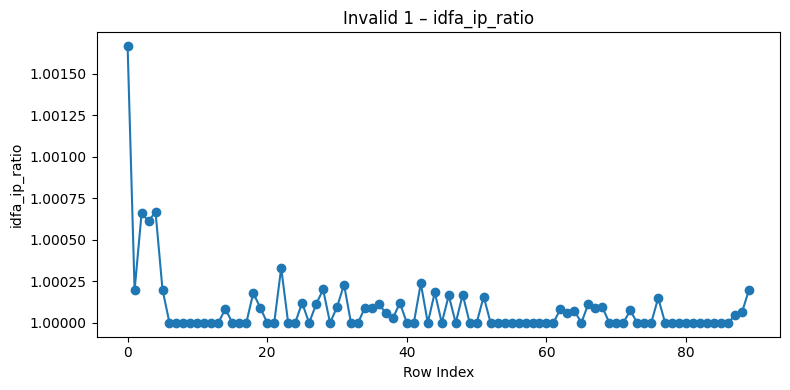

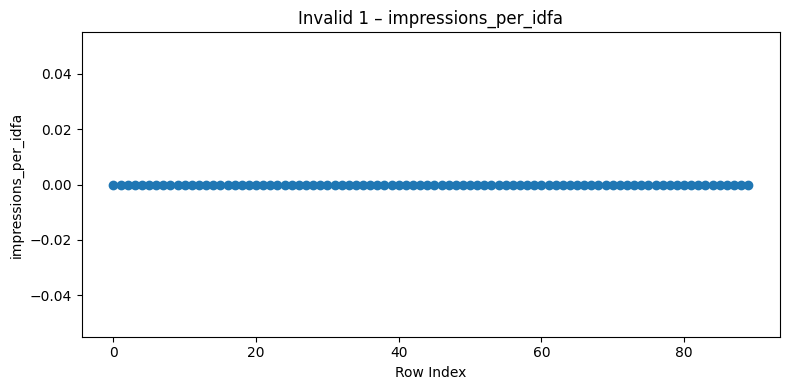

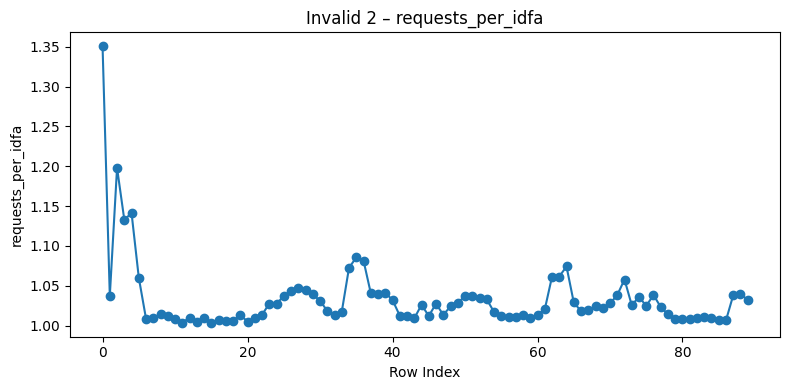

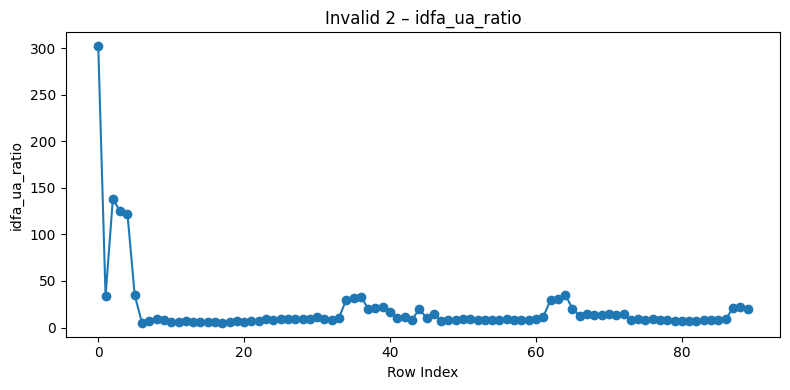

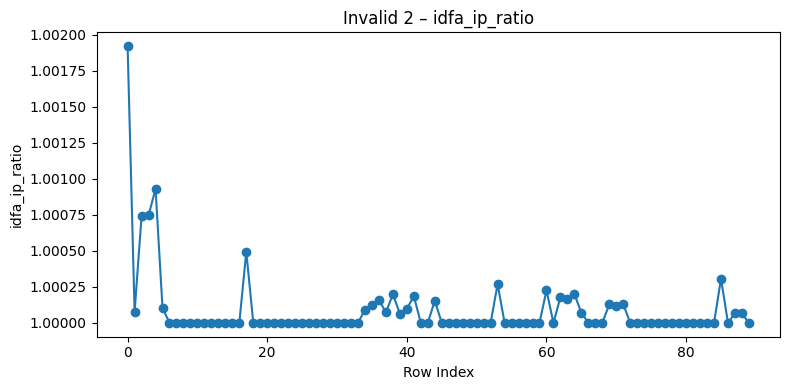

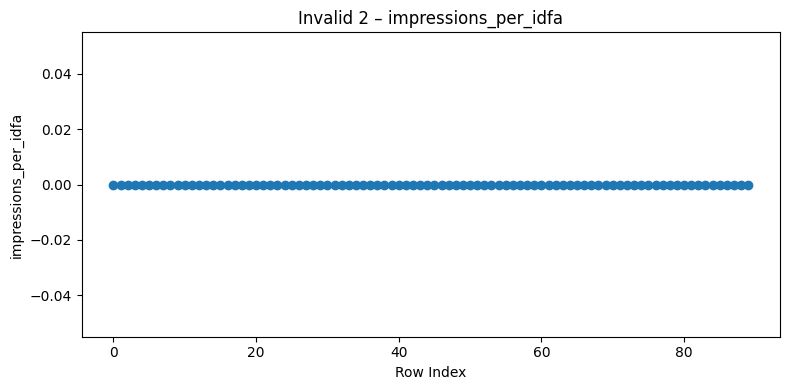

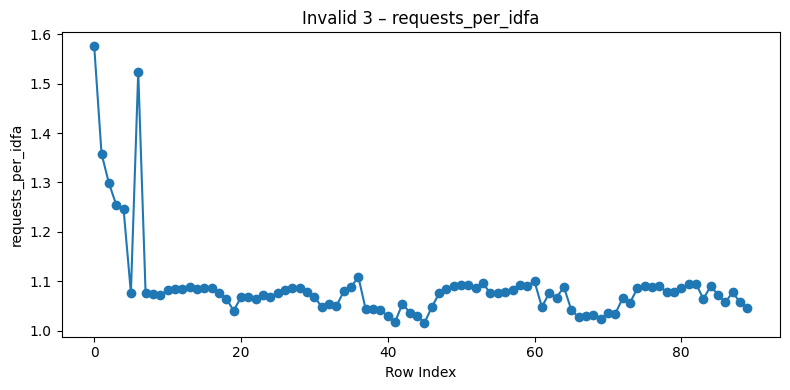

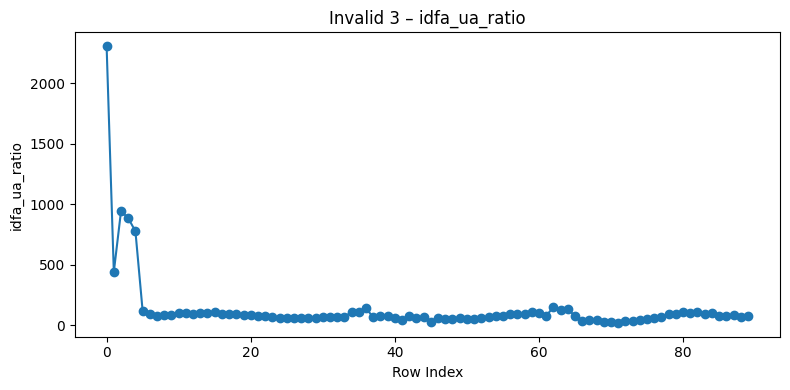

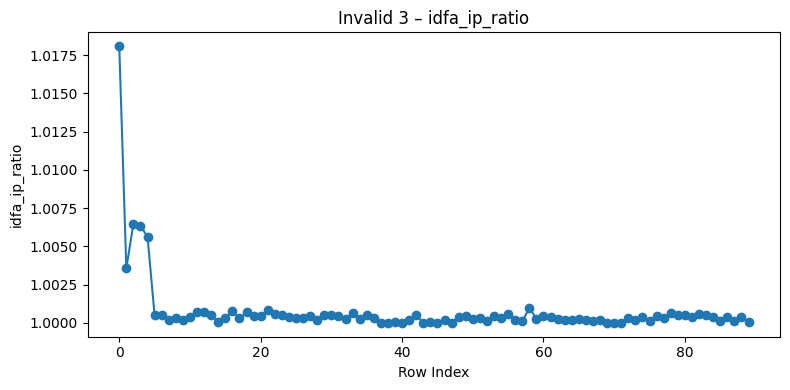

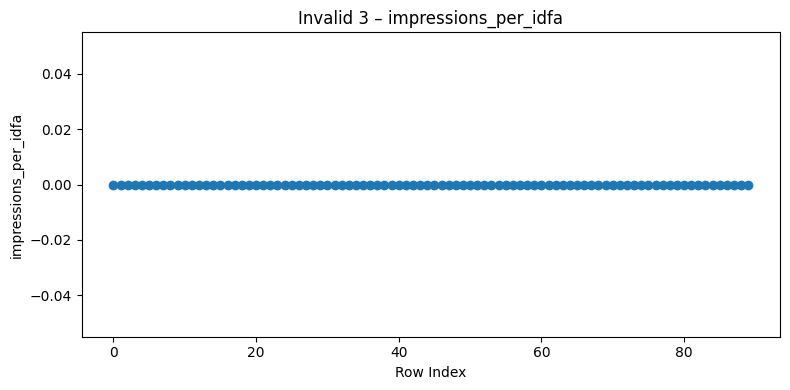

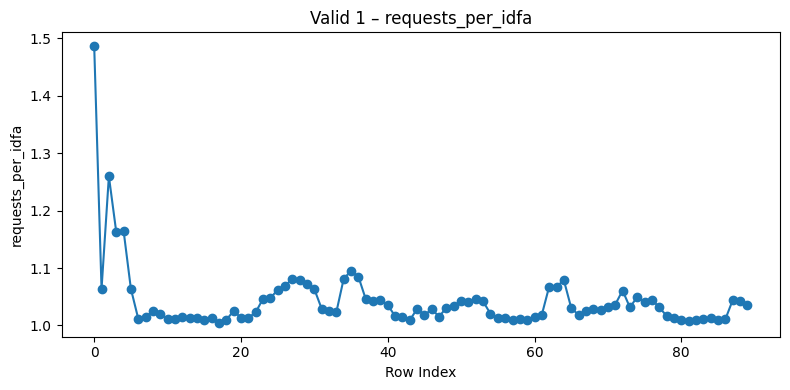

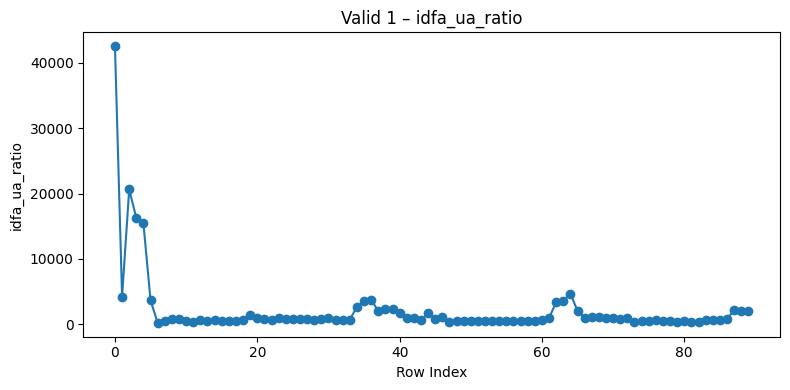

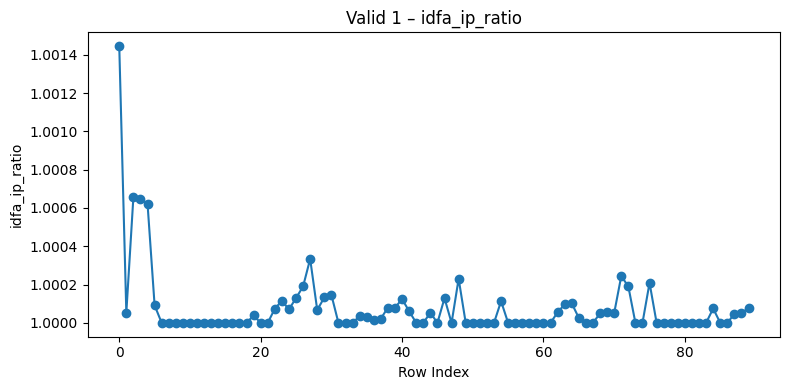

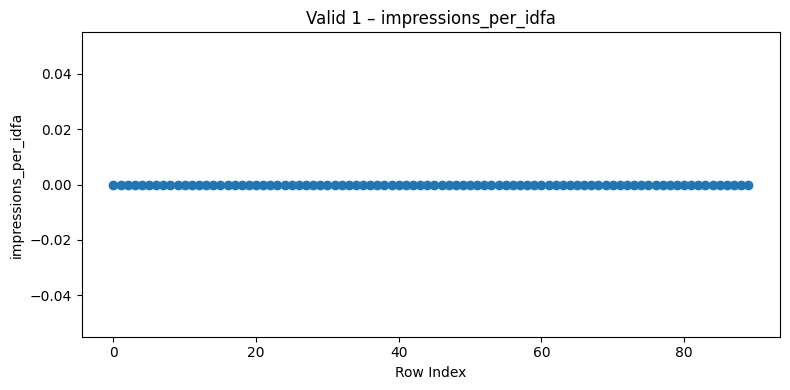

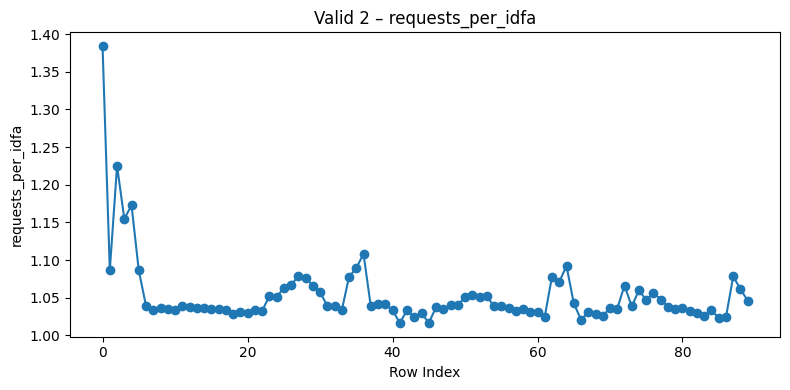

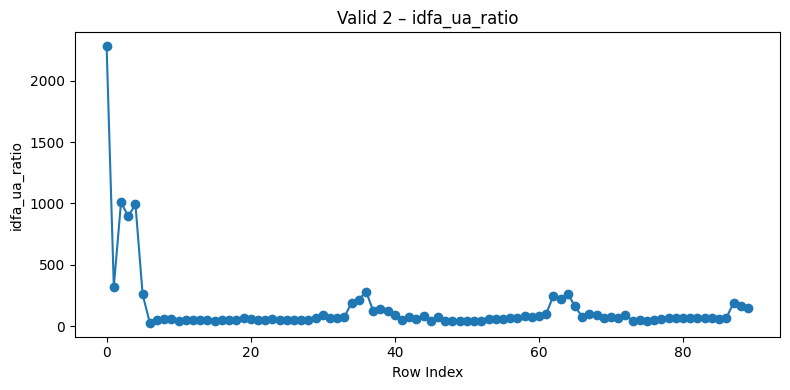

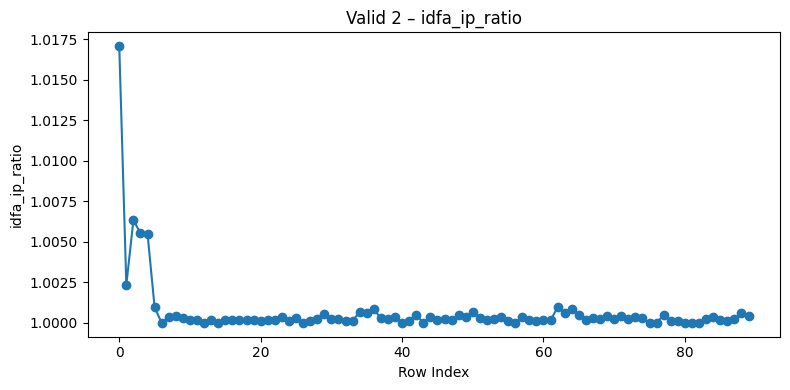

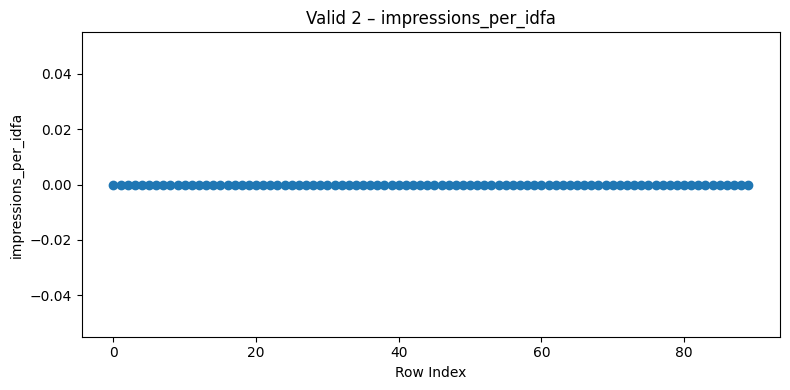

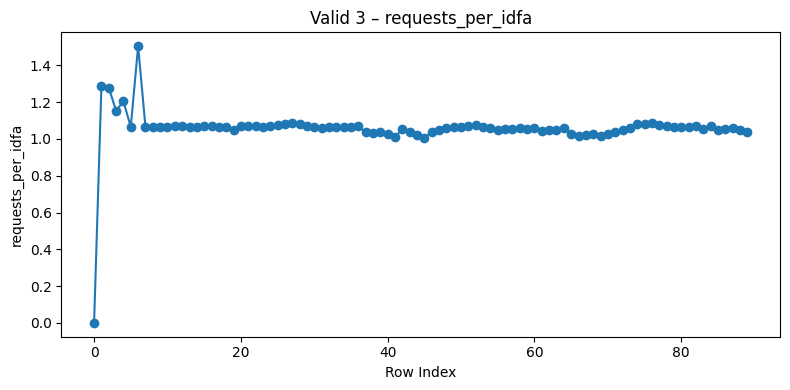

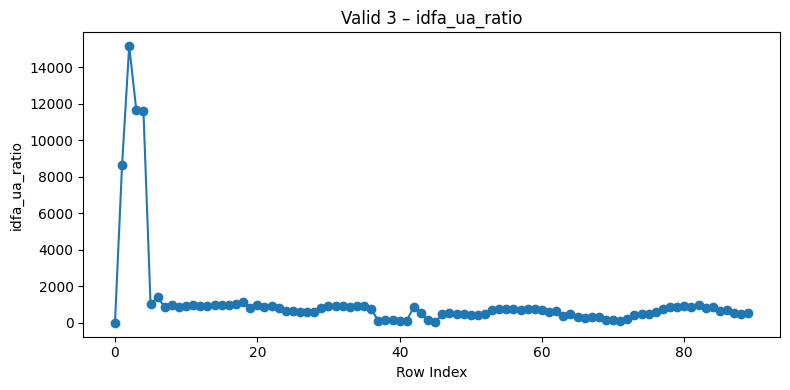

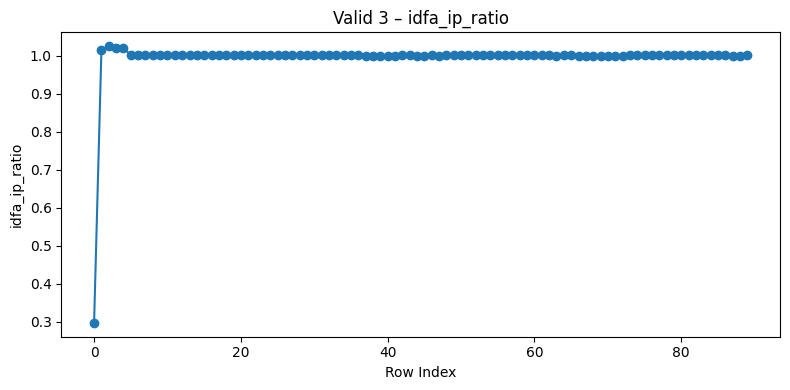

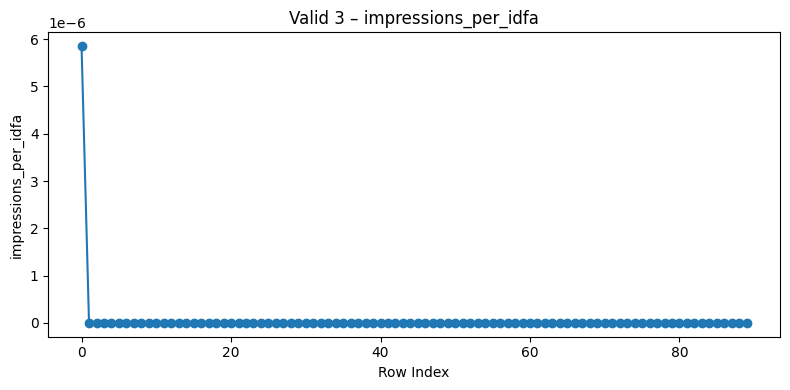

In [13]:
metrics = ["requests_per_idfa","idfa_ua_ratio","idfa_ip_ratio","impressions_per_idfa"]
for sheet, df_s in data.groupby("sheet"):
    if len(df_s)<2:
        continue
    for m in metrics:
        plt.figure(figsize=(8,4))
        vals = df_s[m].replace([np.inf,-np.inf],np.nan).fillna(method='ffill').fillna(0)
        plt.plot(vals.values, marker='o')
        plt.title(f"{sheet} – {m}")
        plt.xlabel("Row Index")
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(plots_folder,f"{sheet}_{m}.png"))
        plt.close()